<center><h1><b><mark style="background-color: #ff1493; color: black;">IP CW Draft</mark></b></h1></center>


In this coursework, you will be asked to develop an image processing pipeline to separate flower material from background. This requires a processing pipeline that usually includes at least some of the following steps:

- <b>Colour space conversion</b>: choose a colour space. Any can be used, but most people choose to work in a lower-dimensional (<3) space whenever possible.

- <b>Noise reduction</b>: depending on image quality, some form of noise suppression may be required.

- <b>Thresholding/Segmentation</b>: image regions corresponding to nuclei must be identified, and thresholding is a common approach. The method used varies and may be global or local. Methods that automatically determine the threshold value  have obvious advantages over those that require user interaction. Binary image processing: Identifying a perfect threshold value or segmentation  method is almost impossible, and most methods will result in some mis-classified  pixels. A further binary image processing stage is often needed to clean up the image, hopefully leaving it containing only regions that correspond to plants.  Nothing, however, is perfect.

- <b>Dataset</b>: Images of three species of flowers are collected in a folder available from  Moodle. The images are selected based on the complexity of their foreground/background features and categorised into three sub-folders (e.g., easy, medium, and hard) within the input-image folder. To aid with analysing the effectiveness of your solution, ground truth for each image is provided within the  ground-truth folder, again categorised within three sub-folders (e.g., easy, medium, and hard).

https://www.researchgate.net/publication/286225842_Flower_recognition_system_based_on_image_processing


In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import imageio
from skimage import morphology
from skimage.segmentation import watershed
from skimage.segmentation import random_walker
from skimage.feature import peak_local_max
from scipy import ndimage
from skimage.measure import regionprops, label


def convert_BW(img):
    
    # converts the image to grayscale
    
    img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_bw

def negation(img):
    # Ensure the image is in uint8 format
    if img.dtype != 'uint8':
        img = img.astype('uint8')
    negated_image = 255 - img
    return negated_image

def inc_gain(img,gain_factor):
    scaled_image = img * gain_factor
    scaled_image[scaled_image > 255] = 255
    return scaled_image

def histogramEq(img):
    # Convert the input image to a supported depth format (e.g., 8-bit)
    img = img.astype(np.uint8)

    # Convert the input image to grayscale if it's in color
    if len(img.shape) > 2:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img

    # Apply histogram equalization
    eq_img = cv2.equalizeHist(gray_img)

    return eq_img

def otsu_threshold(img):
    if len(img.shape) > 2:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    
    if gray_img.dtype != 'uint8':
        gray_img = gray_img.astype('uint8')
    _, otsu_threshold = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return otsu_threshold

def gamma_Correction(img, g):
    gamma = g
    gamma_img = ((img / 255) ** gamma) * 255
    gamma_img = gamma_img.astype("uint8")
    return gamma_img

def calculate_miou(ground_truth, final):
    print(ground_truth.shape)
    print(final.shape)
    similarity = ssim(ground_truth, final)
    return similarity
  
  # roi for flowers using canny edge detection and choosing largest contour assuming that is the flower
def create_flower_mask(image):
    gray_image = image

    bilateral_filtered = cv2.bilateralFilter(gray_image, 9, 75, 75)
    edges = cv2.Canny(bilateral_filtered, 50, 150)
    dilated_edges = cv2.dilate(edges, np.ones((5, 5), np.uint8), iterations=2)

    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    inverted_mask = cv2.bitwise_not(mask)

    roi = cv2.bitwise_and(image, image, mask=mask)
    roi[mask == 0] = 255

    return roi,largest_contour

def erosion(binary_image, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    eroded_image = cv2.erode(binary_image, kernel, iterations=1)
    
    return eroded_image

  
def extract_foreground(image): 
    if image.dtype != 'uint8':
        image = image.astype('uint8')
    height, width = image.shape[:2]
    mask = np.zeros(image.shape[:2], np.uint8)
    rectangle = (1, 1, width, height)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.convertScaleAbs(image)
    cv2.grabCut(image, mask, rectangle, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT) # 5
    foreground_mask = np.where((mask == 1) | (mask == 3), 255, 0).astype('uint8')
    foreground = cv2.bitwise_and(image, image, mask=foreground_mask)
    return foreground


def sharpen_img(image, strength=1.5, sigma=1.0):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened

def roi(binary_image):
    # Invert the colors of the binary image
    inverted_image = np.logical_not(binary_image)
    
    # Label connected components in the inverted binary image
    labeled_image = label(inverted_image)
    
    # Calculate properties of labeled regions
    regions = regionprops(labeled_image)
    
    # Find the label of the largest component (which corresponds to the largest black blob)
    largest_label = max(regions, key=lambda region: region.area).label
    
    # Create a mask containing only the largest component (black blob)
    largest_black_blob_mask = labeled_image == largest_label
    
    # Apply the mask to the inverted binary image to obtain the largest black blob
    largest_black_blob_image = np.zeros_like(binary_image)
    largest_black_blob_image[largest_black_blob_mask] = 1
    
    return largest_black_blob_image

# customizable function to apply all processing functions to image
def image_pipeline(img,ground):
    
    _, ground_t = cv2.threshold(convert_BW(ground), 50, 255, cv2.THRESH_BINARY)
    
    bw_img = convert_BW(img)
    gamma_img= gamma_Correction(bw_img,3.0)
    foreground_img = extract_foreground(gamma_img)
    negated_img = negation(foreground_img)  
    hist_eq_img = histogramEq(negated_img)
    otsu_thresh_img = otsu_threshold(hist_eq_img)
    final_img = roi(otsu_thresh_img)
    
    ground_truth = erosion(negation(ground_t),7)
    

    print("similarity: ",calculate_miou(ground_truth,final_img))

    # display half-processed images
    images = [bw_img, gamma_img, foreground_img, negated_img, hist_eq_img, otsu_thresh_img, final_img, ground_truth]
    titles = ["bw","gamma", "fground", "negate","histogram equalisation", "otsu threshold", "final", "ground_t"]
    fig, axes = plt.subplots(2, 4, figsize=(15, 7))
    for ax, img, title in zip(axes.ravel(), images, titles):
        ax.imshow(img, cmap="gray")
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [2]:
def display_pipeline(image_pipeline):

    file_names = ["easy","medium","hard"]
    input_file_directory = "C:\\Users\\Manoharan\\Desktop\\IP CW\\Dataset\\input_images\\"
    ground_truth_directory =  "C:\\Users\\Manoharan\\Desktop\\IP CW\\Dataset\\ground_truths\\"
    
    for j in file_names:
        
        first_file_directory = input_file_directory+j+"\\"+j+"_"+"1"+".jpg"
        sec_file_directory = input_file_directory+j+"\\"+j+"_"+"2"+".jpg"
        third_file_directory = input_file_directory+j+"\\"+j+"_"+"3"+".jpg"
        
        ground1=ground_truth_directory+j+"\\"+j+"_"+"1"+".png"
        ground2=ground_truth_directory+j+"\\"+j+"_"+"2"+".png"
        ground3=ground_truth_directory+j+"\\"+j+"_"+"3"+".png"

        # getting input images
        image1=cv2.imread(first_file_directory, cv2.IMREAD_COLOR)
        image2=cv2.imread(sec_file_directory, cv2.IMREAD_COLOR)
        image3=cv2.imread(third_file_directory, cv2.IMREAD_COLOR)

        # getting all processed images
        gimage1=cv2.imread(ground1, cv2.IMREAD_COLOR)
        gimage2=cv2.imread(ground2, cv2.IMREAD_COLOR)
        gimage3=cv2.imread(ground3, cv2.IMREAD_COLOR)
        
        # getting final images
        fimage1=image_pipeline(image1,gimage1)
        fimage2=image_pipeline(image2,gimage2)
        fimage3=image_pipeline(image3,gimage3)

(500, 666)
(500, 666)
similarity:  0.5596245935278423


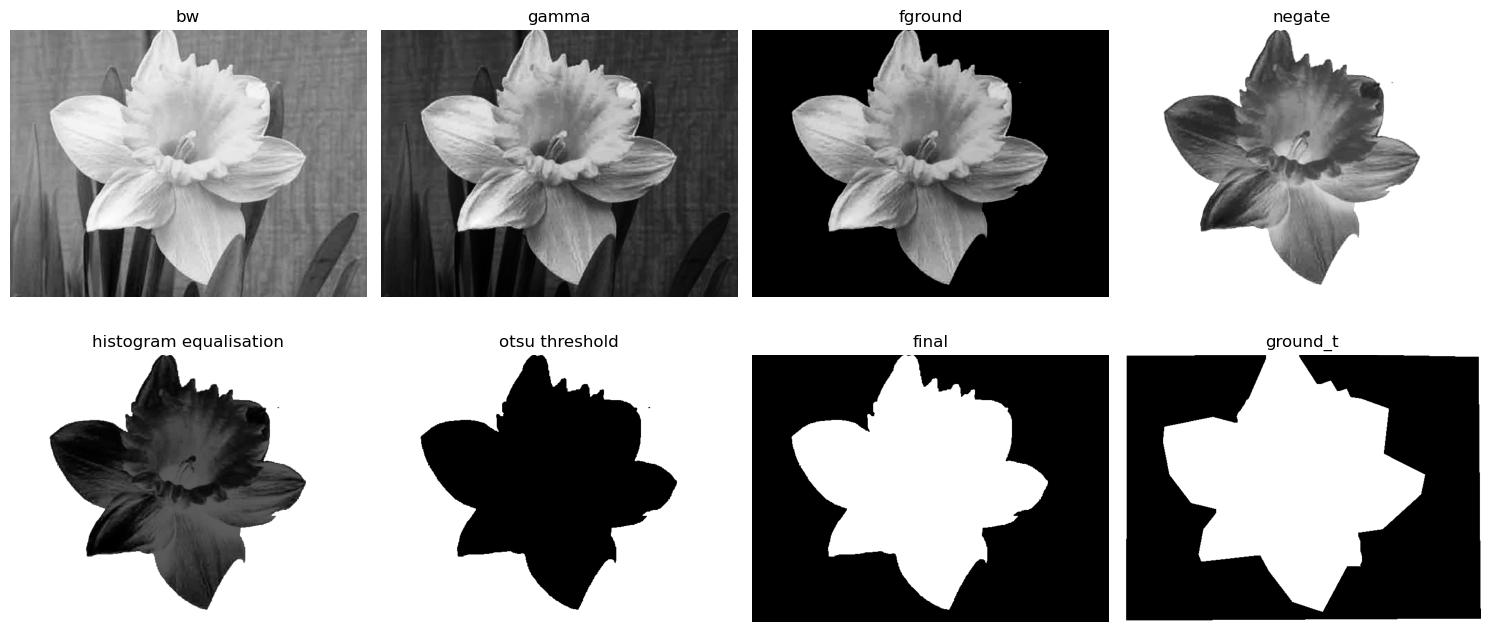

(500, 666)
(500, 666)
similarity:  0.5431357370172905


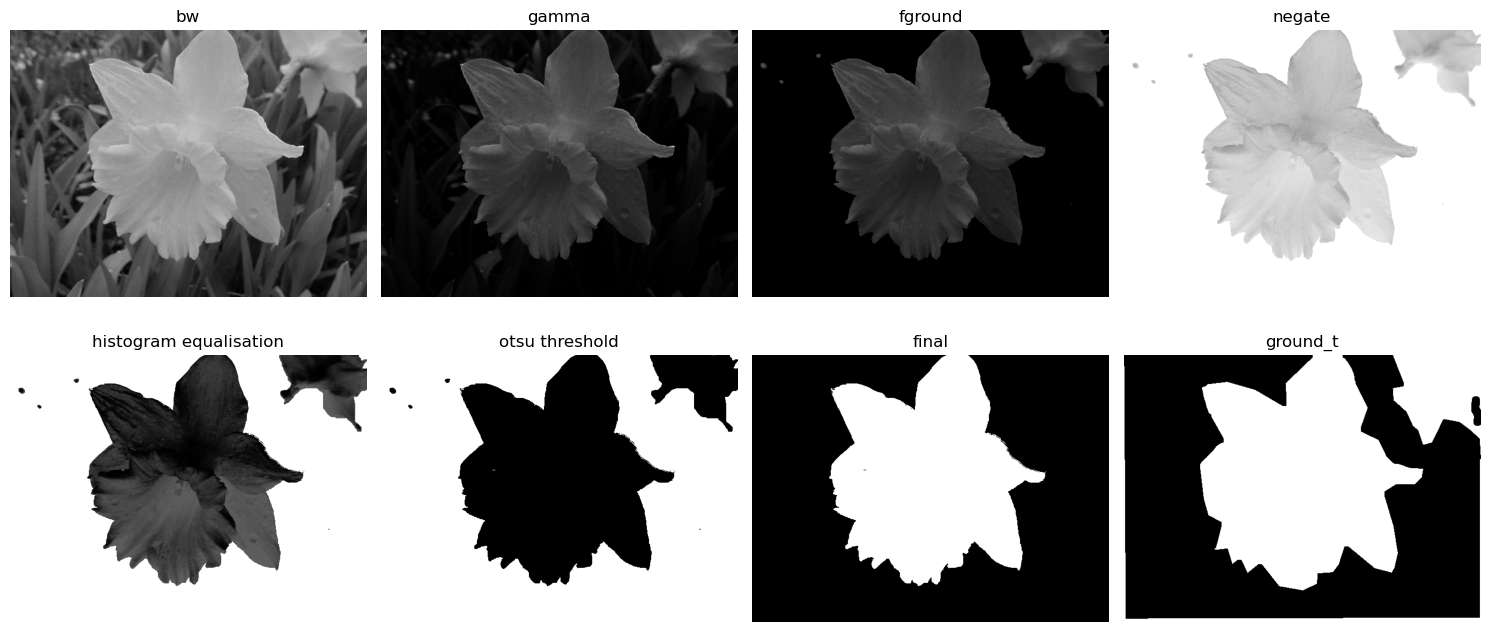

(500, 666)
(500, 666)
similarity:  0.6860002089784026


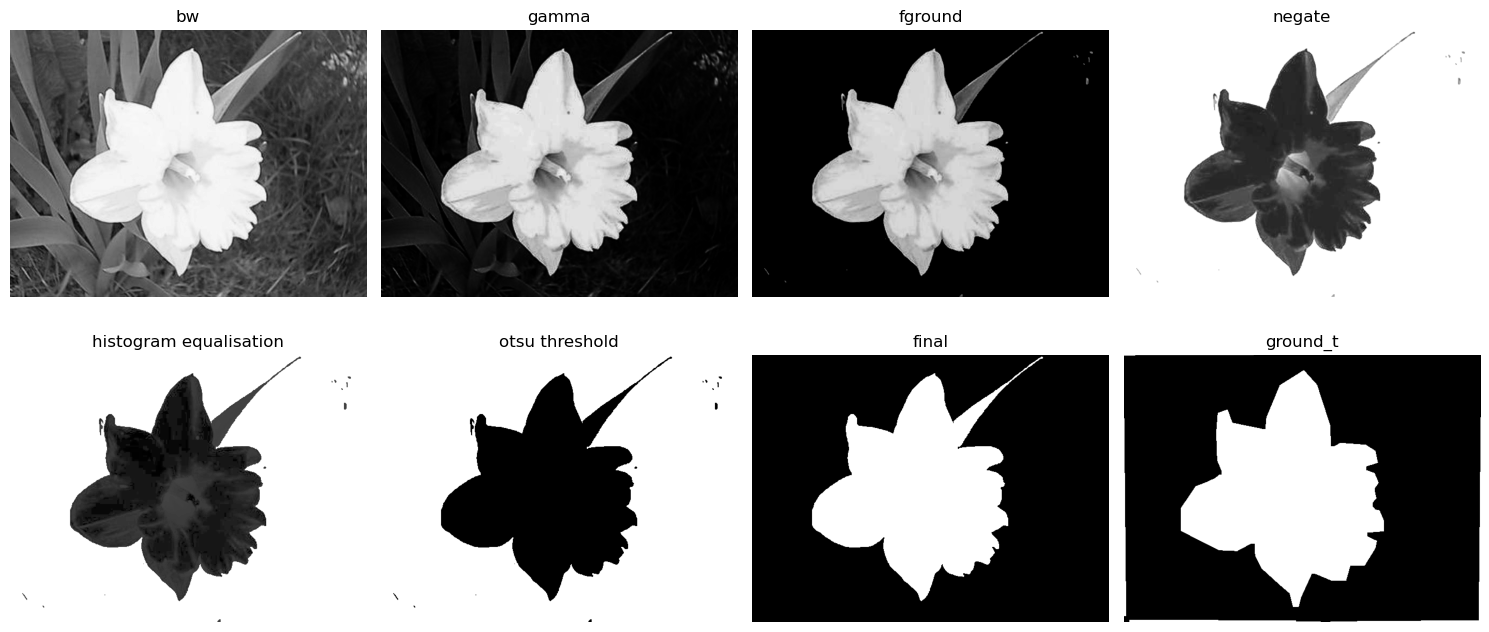

(529, 500)
(529, 500)
similarity:  0.4121890311566751


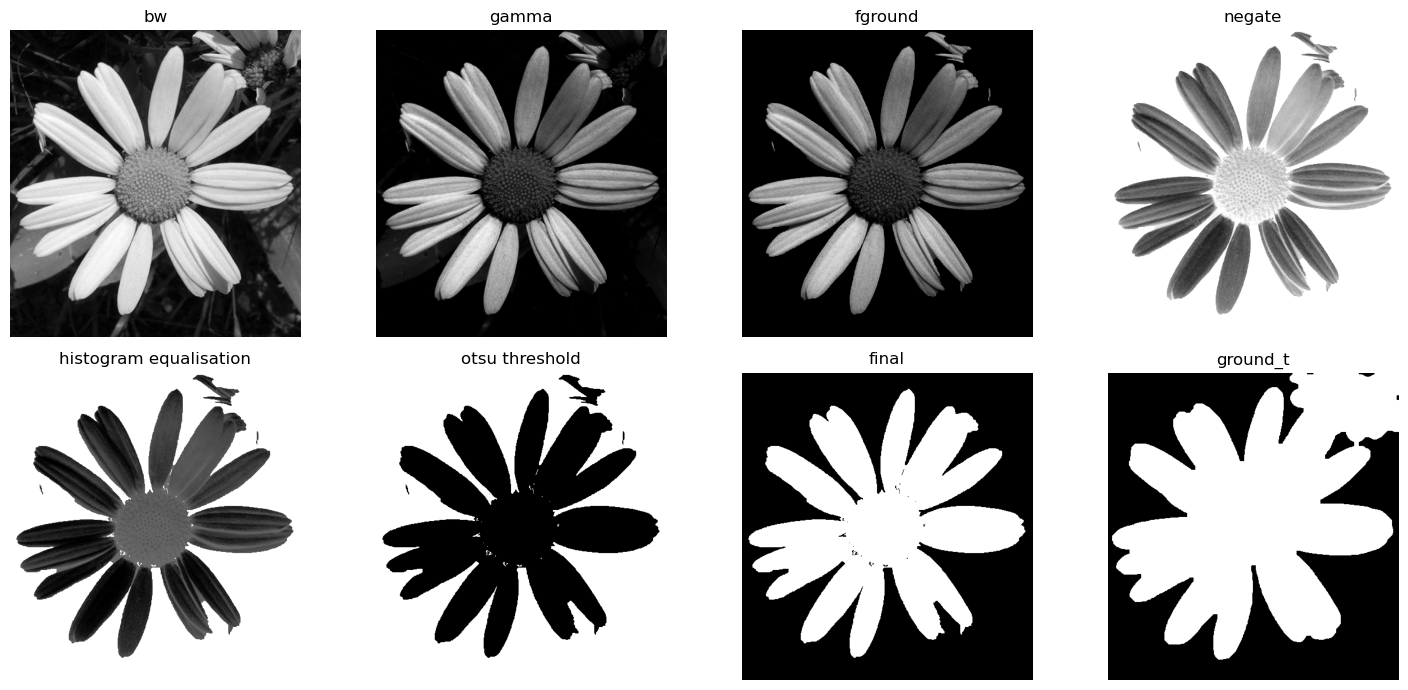

(500, 750)
(500, 750)
similarity:  0.4785802939775734


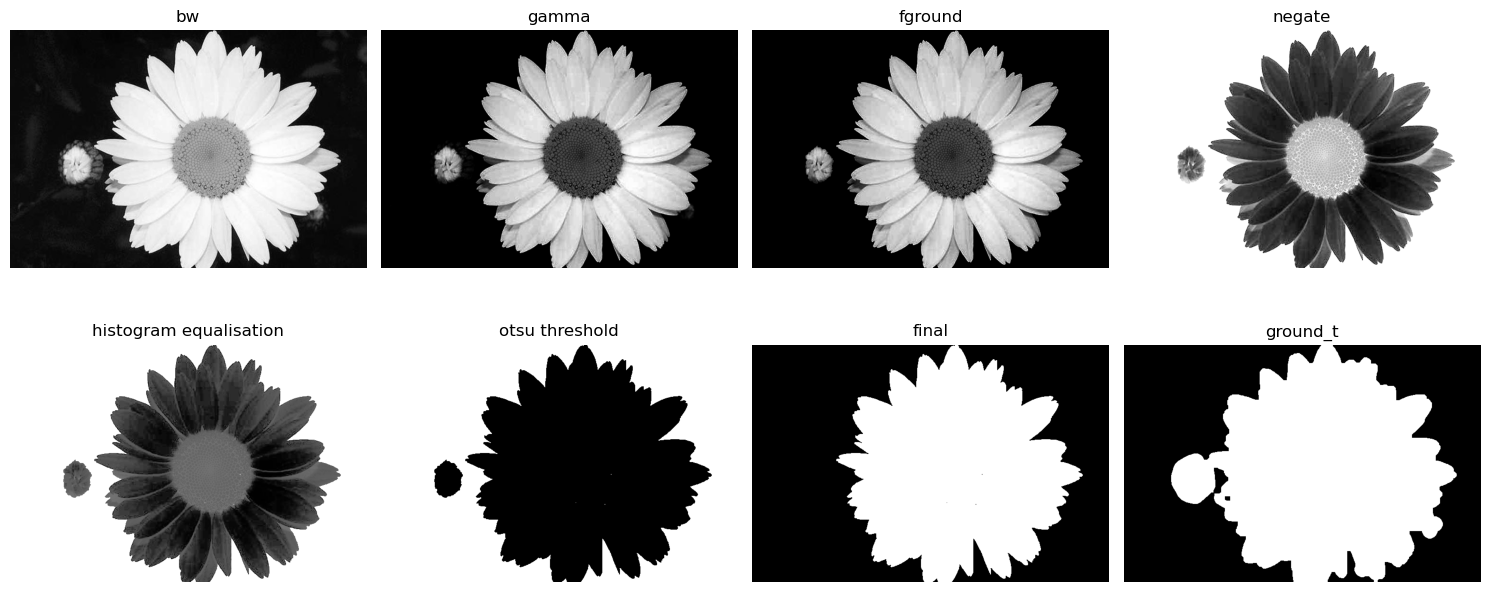

(500, 538)
(500, 538)
similarity:  0.41923527780911


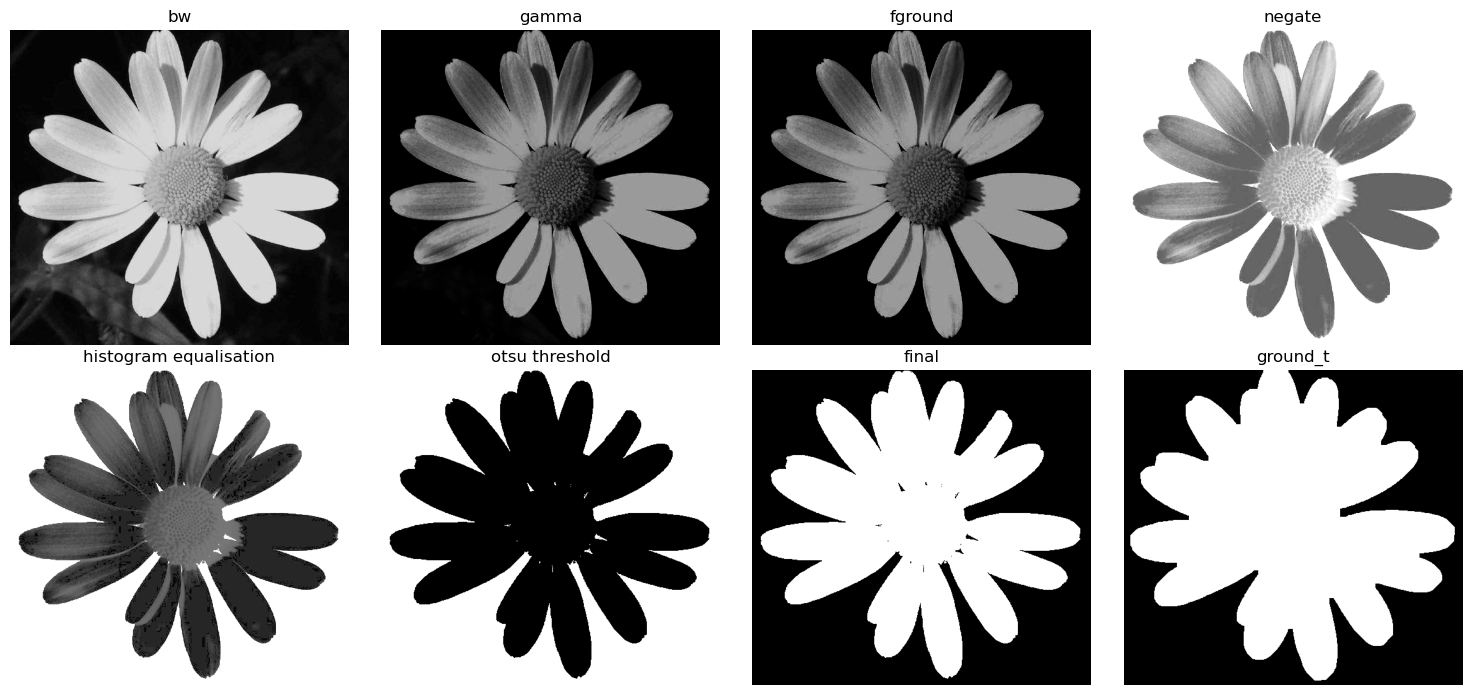

(500, 518)
(500, 518)
similarity:  0.3837931171781075


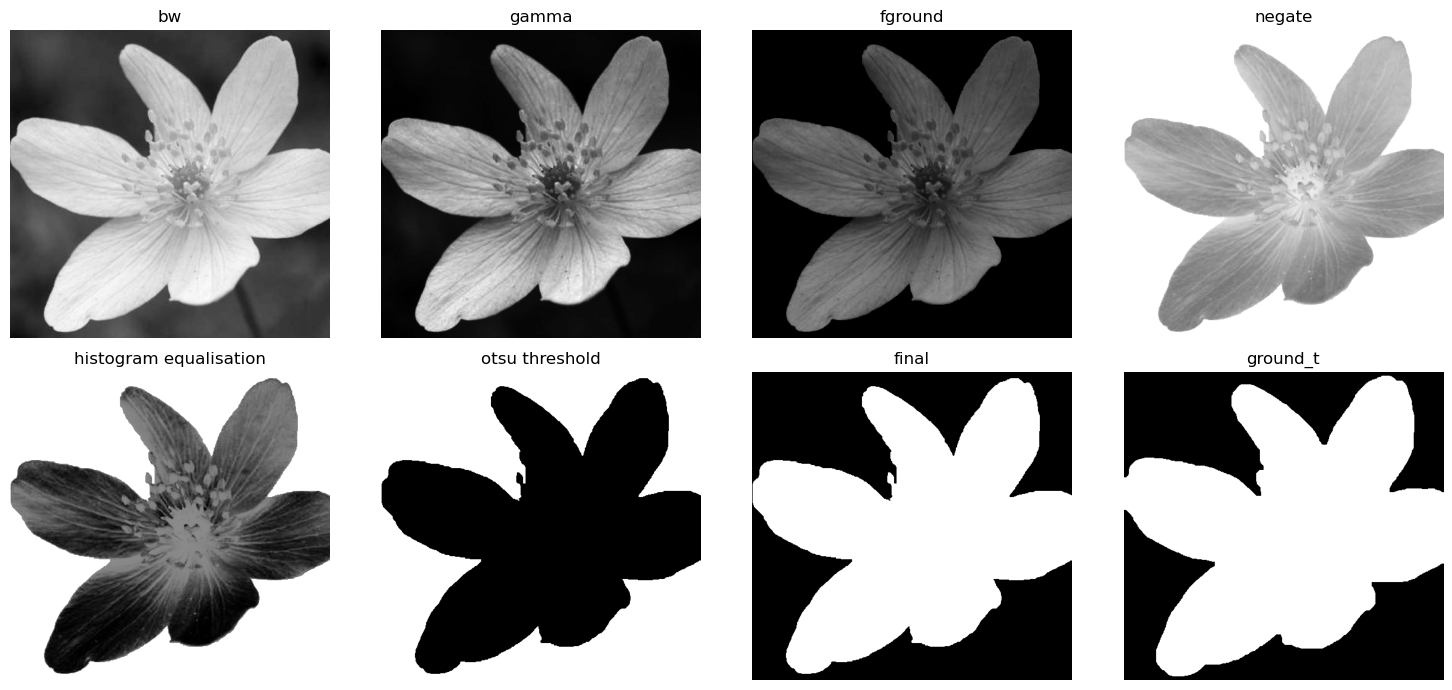

(500, 600)
(500, 600)
similarity:  0.45298680838551814


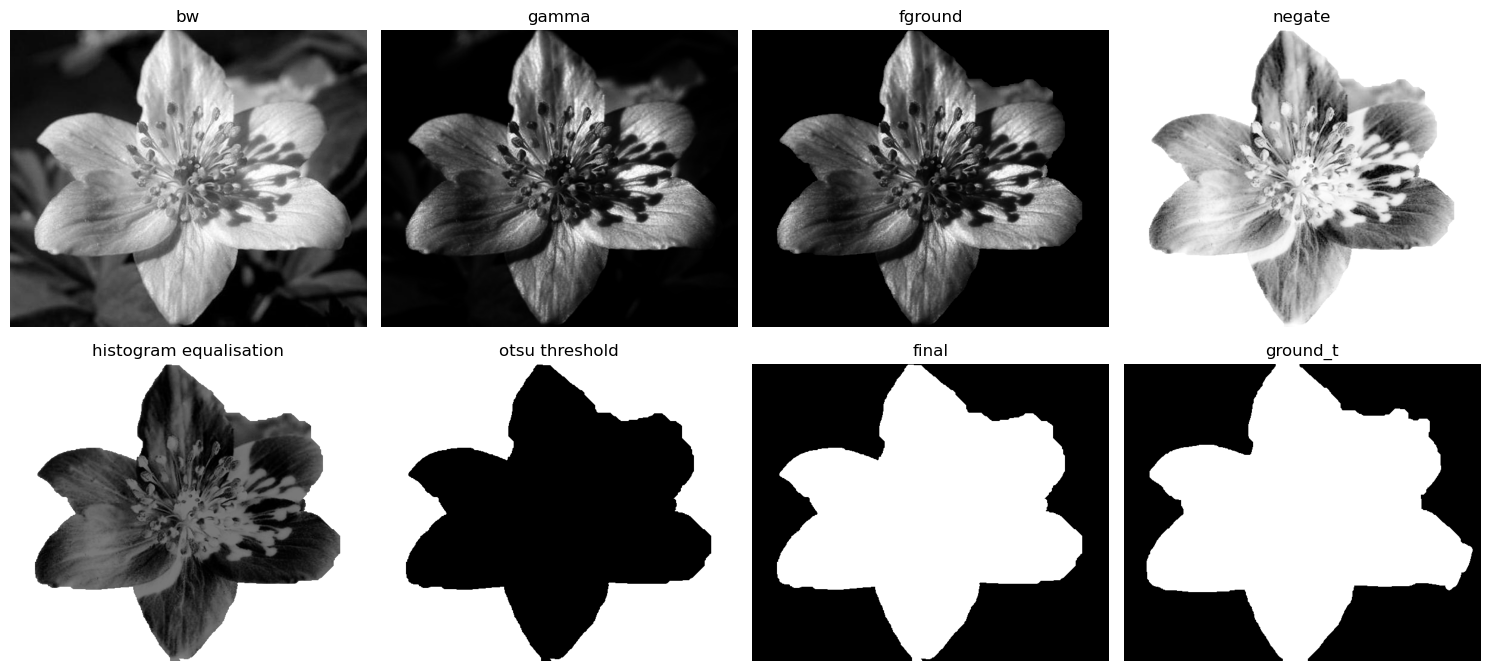

(500, 500)
(500, 500)
similarity:  0.4224748928471284


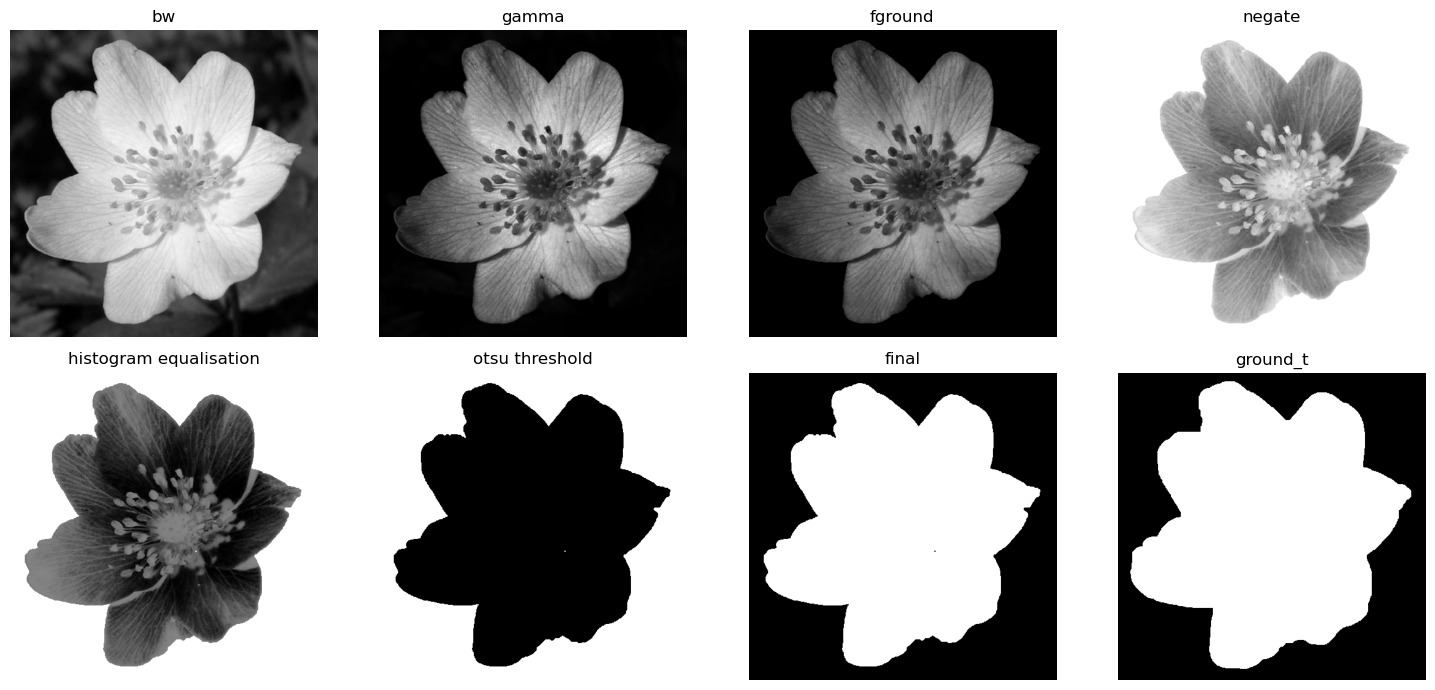

In [13]:
display_pipeline(image_pipeline)